In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [2]:
train_data = pd.read_csv('dataset_train.csv')
# Default label 0 = glaucoma 1 = normal 2 = others
train_data.loc[train_data.label == 1, 'label'] = 3
train_data.loc[train_data.label == 2, 'label'] = 1
train_data.loc[train_data.label == 3, 'label'] = 0
train_data['label'] = train_data['label'].astype(str)
Y = train_data[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)


idg = ImageDataGenerator(rescale = 1./255,
                        shear_range = 0.2,
                        zoom_range = 0.2,
                        horizontal_flip = True)

In [3]:
def create_new_model():
    IMAGE_SIZE = [32, 32]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [4]:
def main():
    VALIDATION_ACCURACY = []
    VALIDATION_LOSS = []
    
    image_dir = 'dataset_train'
    save_dir = 'osaved_models/'
    fold_var = 1
    num_epochs = 15
    
    for train_index, val_index in skf.split(np.zeros(3234),Y):

        training_data = train_data.iloc[train_index]
        validation_data = train_data.iloc[val_index]
        
        train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
                                                       x_col = 'filename', y_col = 'label',
                                                       target_size = (32, 32),batch_size = 16,
                                                       class_mode = "binary", shuffle = True)
        valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)
        # CREATE NEW MODEL
        model = create_new_model()

        # COMPILE NEW MODEL
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        # CREATE CALLBACKS
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + get_model_name(fold_var),
                                                        monitor='val_accuracy', verbose=1,
                                                        save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model

        # FIT THE MODEL
        history = model.fit_generator(train_data_generator,
                            epochs=15,
                            callbacks=callbacks_list,
                            validation_data=valid_data_generator)
        
        # Extract valid_data_generator
        valid_data_generator.reset()
        
        X_test, y_test = next(valid_data_generator)
        
        batch_index = 0
        while batch_index <= valid_data_generator.batch_index:
            img, label = next(valid_data_generator)
            X_test = np.append(X_test, img, axis=0 )
            y_test = np.append(y_test, label, axis=0)
            batch_index = batch_index + 1
        
                
        # PLOT HISTORY        
        y_pred = model.predict(X_test).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
        
        from sklearn.metrics import auc
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='ROC fold {} (AUC = {:.2f})'.format(fold_var,auc_keras))

        # LOAD BEST MODEL to evaluate the performance of the model
        model.load_weights("osaved_models/model_" + str(fold_var) + ".h5")

        results = model.evaluate(valid_data_generator)
        results = dict(zip(model.metrics_names, results))
        
                
        VALIDATION_ACCURACY.append(results['accuracy'])
        VALIDATION_LOSS.append(results['loss'])
        
        tf.keras.backend.clear_session()
        
        fold_var += 1
        
    plt.xlabel('False Positive Rate (Positive label: 1)')
    plt.ylabel('True Positive Rate (Positive label: 1)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='best')
    plt.savefig('Graph/vgg16_others_graph.jpg')
    plt.show()  

Found 2587 validated image filenames belonging to 2 classes.
Found 647 validated image filenames belonging to 2 classes.


c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 16s 83ms/step - loss: 0.5092 - accuracy: 0.7739 - val_loss: 0.4772 - val_accuracy: 0.7852

Epoch 00001: val_accuracy improved from -inf to 0.78516, saving model to osaved_models\model_1.h5
Epoch 2/15
162/162 [==============================] - 12s 72ms/step - loss: 0.4571 - accuracy: 0.7926 - val_loss: 0.4475 - val_accuracy: 0.7944

Epoch 00002: val_accuracy improved from 0.78516 to 0.79444, saving model to osaved_models\model_1.h5
Epoch 3/15
162/162 [==============================] - 12s 73ms/step - loss: 0.4434 - accuracy: 0.7895 - val_loss: 0.4354 - val_accuracy: 0.8022

Epoch 00003: val_accuracy improved from 0.79444 to 0.80216, saving model to osaved_models\model_1.h5
Epoch 4/15
162/162 [==============================] - 12s 74ms/step - loss: 0.4111 - accuracy: 0.8144 - val_loss: 0.4259 - val_accuracy: 0.7960

Epoch 00004: val_accuracy did not improve from 0.80216
Epoch 5/15
162/162 [==============================] - 12s 74ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 76ms/step - loss: 0.6167 - accuracy: 0.6387 - val_loss: 0.4852 - val_accuracy: 0.7805

Epoch 00001: val_accuracy improved from -inf to 0.78053, saving model to osaved_models\model_2.h5
Epoch 2/15
162/162 [==============================] - 12s 75ms/step - loss: 0.4779 - accuracy: 0.7780 - val_loss: 0.4491 - val_accuracy: 0.7852

Epoch 00002: val_accuracy improved from 0.78053 to 0.78516, saving model to osaved_models\model_2.h5
Epoch 3/15
162/162 [==============================] - 12s 75ms/step - loss: 0.4722 - accuracy: 0.7786 - val_loss: 0.4376 - val_accuracy: 0.7805

Epoch 00003: val_accuracy did not improve from 0.78516
Epoch 4/15
162/162 [==============================] - 12s 75ms/step - loss: 0.4195 - accuracy: 0.8143 - val_loss: 0.4201 - val_accuracy: 0.8037

Epoch 00004: val_accuracy improved from 0.78516 to 0.80371, saving model to osaved_models\model_2.h5
Epoch 5/15
162/162 [==============================] - 12s 75ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 77ms/step - loss: 0.5670 - accuracy: 0.7208 - val_loss: 0.4765 - val_accuracy: 0.7759

Epoch 00001: val_accuracy improved from -inf to 0.77589, saving model to osaved_models\model_3.h5
Epoch 2/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4689 - accuracy: 0.7881 - val_loss: 0.4462 - val_accuracy: 0.8083

Epoch 00002: val_accuracy improved from 0.77589 to 0.80835, saving model to osaved_models\model_3.h5
Epoch 3/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4785 - accuracy: 0.7684 - val_loss: 0.4332 - val_accuracy: 0.7913

Epoch 00003: val_accuracy did not improve from 0.80835
Epoch 4/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4368 - accuracy: 0.7923 - val_loss: 0.4030 - val_accuracy: 0.8192

Epoch 00004: val_accuracy improved from 0.80835 to 0.81917, saving model to osaved_models\model_3.h5
Epoch 5/15
162/162 [==============================] - 12s 76ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 13s 77ms/step - loss: 0.5347 - accuracy: 0.7646 - val_loss: 0.4769 - val_accuracy: 0.7821

Epoch 00001: val_accuracy improved from -inf to 0.78207, saving model to osaved_models\model_4.h5
Epoch 2/15
162/162 [==============================] - 12s 77ms/step - loss: 0.4636 - accuracy: 0.7885 - val_loss: 0.4569 - val_accuracy: 0.7836

Epoch 00002: val_accuracy improved from 0.78207 to 0.78362, saving model to osaved_models\model_4.h5
Epoch 3/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4358 - accuracy: 0.7970 - val_loss: 0.4432 - val_accuracy: 0.7898

Epoch 00003: val_accuracy improved from 0.78362 to 0.78980, saving model to osaved_models\model_4.h5
Epoch 4/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4196 - accuracy: 0.8104 - val_loss: 0.4366 - val_accuracy: 0.7898

Epoch 00004: val_accuracy did not improve from 0.78980
Epoch 5/15
162/162 [==============================] - 12s 76ms/st

c:\users\vivet\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
162/162 [==============================] - 14s 83ms/step - loss: 0.5322 - accuracy: 0.7629 - val_loss: 0.4697 - val_accuracy: 0.7786

Epoch 00001: val_accuracy improved from -inf to 0.77864, saving model to osaved_models\model_5.h5
Epoch 2/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4727 - accuracy: 0.7683 - val_loss: 0.4503 - val_accuracy: 0.7864

Epoch 00002: val_accuracy improved from 0.77864 to 0.78638, saving model to osaved_models\model_5.h5
Epoch 3/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4605 - accuracy: 0.7846 - val_loss: 0.4358 - val_accuracy: 0.8080

Epoch 00003: val_accuracy improved from 0.78638 to 0.80805, saving model to osaved_models\model_5.h5
Epoch 4/15
162/162 [==============================] - 12s 76ms/step - loss: 0.4304 - accuracy: 0.8038 - val_loss: 0.4216 - val_accuracy: 0.8050

Epoch 00004: val_accuracy did not improve from 0.80805
Epoch 5/15
162/162 [==============================] - 12s 76ms/st

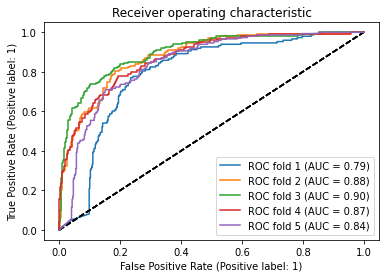

In [5]:
main()

Found 810 validated image filenames belonging to 2 classes.
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88       624
         1.0       0.63      0.20      0.30       186

    accuracy                           0.79       810
   macro avg       0.71      0.58      0.59       810
weighted avg       0.76      0.79      0.74       810

[[602  22]
 [149  37]]


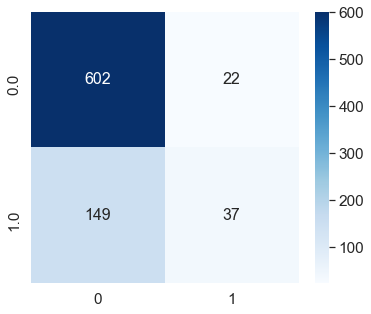

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
test_data = pd.read_csv('dataset_test.csv')
#default label 0 = glaucoma 1 = normal 2 = others
test_data.loc[test_data.label == 1, 'label'] = 3
test_data.loc[test_data.label == 2, 'label'] = 1
test_data.loc[test_data.label == 3, 'label'] = 0
test_data['label'] = test_data['label'].astype(str)

image_dir = 'dataset_test'

test_generator = ImageDataGenerator(rescale=1./255)

test_data_generator  = test_generator.flow_from_dataframe(test_data, directory = image_dir,
                                                        x_col = 'filename', y_col = 'label',
                                                        target_size = (32, 32),batch_size = 16,
                                                        class_mode = "binary", shuffle = True)

test_data_generator.reset()
        
X_test, y_test = next(test_data_generator)
        
batch_index = 0
while batch_index <= test_data_generator.batch_index:
    img, label = next(test_data_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
    batch_index = batch_index + 1
# CREATE NEW MODEL
model = create_new_model()

# COMPILE NEW MODEL
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])      
model.load_weights("osaved_models/model_3.h5")
y_pred = model.predict(X_test)
y_pred = np.transpose(y_pred)[0]
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, y_pred))

from sklearn.metrics import classification_report
import seaborn as sn
print(classification_report(y_test, y_pred))

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data,index = np.unique(y_test))
plt.figure(figsize = (6,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt="d")
plt.savefig('Matrix/vgg16_other_matrix.jpg')

print(data)